<a href="https://colab.research.google.com/github/TheCaveOfAdullam/study2/blob/main/overfeat_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_curve

In [5]:
# 경로 정의
train_dir = '/content/drive/MyDrive/ship_motor/train'
validation_dir = '/content/drive/MyDrive/ship_motor/validation'
test_dir = '/content/drive/MyDrive/ship_motor/test'

# 변경된 이미지 크기와 배치 크기
image_size = (224, 224)
batch_size = 32

# # 이미지 데이터 증강
# datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# 이미지 데이터셋 로드
train_dataset = image_dataset_from_directory(train_dir, image_size=image_size, batch_size=batch_size, label_mode='int')
validation_dataset = image_dataset_from_directory(validation_dir, image_size=image_size, batch_size=batch_size, label_mode='int')
test_dataset = image_dataset_from_directory(test_dir, image_size=image_size, batch_size=batch_size, label_mode='int')

Found 7004 files belonging to 4 classes.
Found 1278 files belonging to 4 classes.
Found 1278 files belonging to 4 classes.


In [6]:
# ResNet50 모델 불러오기
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 기존의 top 레이어 추가
model = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),  # 첫 번째 드롭아웃 추가
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),  # 모델 복잡도 조정 및 정규화
    Dropout(0.5),  # 두 번째 드롭아웃 추가
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),  # 중간에 또 하나의 Dense 레이어 추가
    Dropout(0.5),  # 세 번째 드롭아웃 추가
    Dense(4, activation='softmax')  # 4개의 클래스
])

# 모델 컴파일
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 조기 종료 및 학습률 감소 콜백 정의
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.000000001)

94765736/94765736 [==============================] - 1s 0us/step


In [7]:
# 모델 학습
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=10, callbacks=[reduce_lr, early_stopping])

Epoch 1/10
219/219 [==============================] - 502s 2s/step - loss: 2.1381 - accuracy: 0.9864 - val_loss: 0.4651 - val_accuracy: 0.9937 - lr: 0.0010
Epoch 2/10
219/219 [==============================] - 445s 2s/step - loss: 0.2184 - accuracy: 0.9999 - val_loss: 0.0946 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/10
219/219 [==============================] - 441s 2s/step - loss: 0.0835 - accuracy: 0.9991 - val_loss: 0.0444 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/10
219/219 [==============================] - 439s 2s/step - loss: 0.0472 - accuracy: 0.9996 - val_loss: 0.0323 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/10
219/219 [==============================] - 439s 2s/step - loss: 0.0248 - accuracy: 0.9997 - val_loss: 0.1149 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 6/10
219/219 [==============================] - 437s 2s/step - loss: 0.3276 - accuracy: 0.9734 - val_loss: 9.9208 - val_accuracy: 0.5853 - lr: 0.0010
Epoch 7/10
219/219 [==============================] - 437s 2s/st

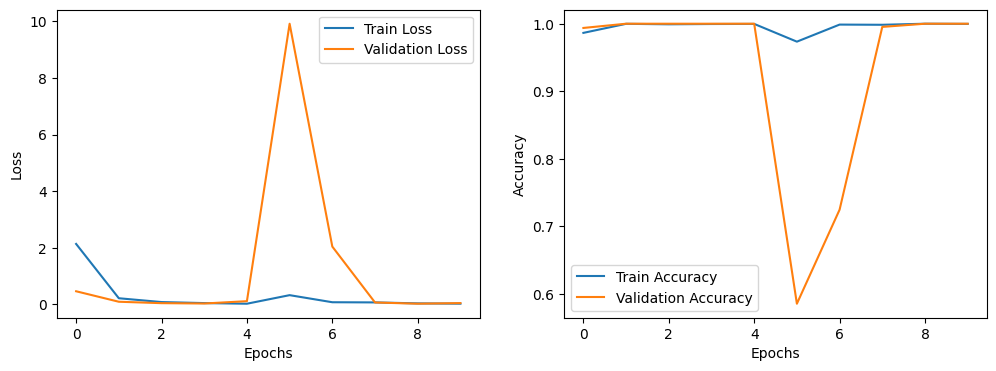

In [8]:
# 학습 과정 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [9]:
# 모델 검증
val_loss, val_acc = model.evaluate(validation_dataset)
print(f"검증 손실: {val_loss}")
print(f"검증 정확도: {val_acc}")

40/40 [==============================] - 22s 525ms/step - loss: 0.0469 - accuracy: 1.0000
검증 손실: 0.04692905768752098
검증 정확도: 1.0


In [10]:
# 모델 테스트
test_loss, test_acc = model.evaluate(test_dataset)
print(f"테스트 손실: {test_loss}")
print(f"테스트 정확도: {test_acc}")

40/40 [==============================] - 23s 504ms/step - loss: 0.0507 - accuracy: 1.0000
테스트 손실: 0.05070613697171211
테스트 정확도: 1.0


In [11]:
# 혼동 행렬 계산
y_true = []
y_pred = []

for batch in test_dataset:
    images, labels = batch
    y_true.extend(labels.numpy())
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))

conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

1/1 [==============================] - 1s 1s/step
Confusion Matrix:
[[176   0   0   0]
 [  0 176   0   0]
 [  0   0 176   0]
 [  0   0   0 750]]


In [12]:
# Classification Report
class_report = classification_report(y_true, y_pred)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       176
           1       1.00      1.00      1.00       176
           2       1.00      1.00      1.00       176
           3       1.00      1.00      1.00       750

    accuracy                           1.00      1278
   macro avg       1.00      1.00      1.00      1278
weighted avg       1.00      1.00      1.00      1278



In [13]:
# F1 Score
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"F1 Score: {f1}")

F1 Score: 1.0
